In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data = pd.read_csv('tweets.csv', encoding='iso-8859-1')

In [35]:
data['tweet_text'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<ipython-input-33-0841e88a6c3a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emotion.index, rotation=-35, ha='left');


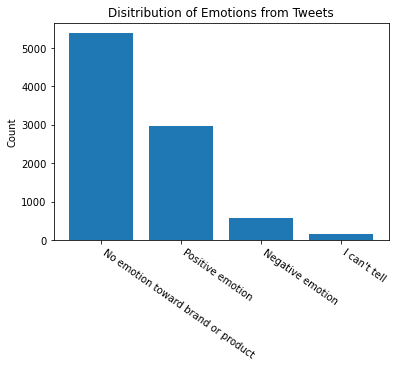

In [33]:
emotion = data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

fig, ax = plt.subplots()
ax.bar(x=emotion.index, height=emotion)

ax.set_title('Disitribution of Emotions from Tweets');
ax.set_xticklabels(emotion.index, rotation=-35, ha='left');
ax.set_ylabel('Count');